In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
# import torch, numpy as np, random
# seed = 42
# torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

In [3]:
df = pd.read_csv('training_dataset.csv',sep=";")
df

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,543,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,19.34,10.0
1,539,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,19.64,9.0
2,534,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,23.36,5.0
3,351,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,20.14,7.0
4,353,"E4S 57,055",20210601,04:00:00,240,48,16,8,4,17.70,7.0
...,...,...,...,...,...,...,...,...,...,...,...
1850810,1443,"E4S 57,055",20211223,07:17:00,437,87,29,14,7,20.54,5.0
1850811,1079,"E4S 56,780",20211223,07:17:00,437,87,29,14,7,18.64,14.0
1850812,1076,"E4S 55,620",20211223,07:17:00,437,87,29,14,7,18.32,10.0
1850813,751,"E4S 55,620",20211223,07:17:00,437,87,29,14,7,18.94,12.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850815 entries, 0 to 1850814
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   DP_ID         int64  
 1   PORTAL        object 
 2   Date          int64  
 3   Time          object 
 4   Interval_1    int64  
 5   Interval_5    int64  
 6   Interval_15   int64  
 7   Interval_30   int64  
 8   Interval_60   int64  
 9   SPEED_MS_AVG  float64
 10  FLOW          float64
dtypes: float64(2), int64(7), object(2)
memory usage: 155.3+ MB


In [5]:
df.isna().sum()

,0
DP_ID,0
PORTAL,0
Date,0
Time,0
Interval_1,0
Interval_5,0
Interval_15,0
Interval_30,0
Interval_60,0
SPEED_MS_AVG,0


In [6]:
df['datetime'] = pd.to_datetime(df['Date'].astype(str)+" "+df['Time'],
                  format='%Y%m%d %H:%M:%S')

In [7]:
test_df1 = pd.read_csv("final_evaluation_dataset.csv",sep=";")
test_df2 = pd.read_csv("evaluation_dataset.csv",sep=";")
combined_df = pd.concat([test_df1, test_df2], ignore_index=True)
combined_df = combined_df.drop_duplicates(subset=["DP_ID", "PORTAL", "Date", "Time"])
combined_df = combined_df.sort_values(by=["PORTAL", "Date", "Time"]).reset_index(drop=True)
combined_df.to_csv("combined_evaluation_dataset.csv", index=False)

In [8]:
test_df = pd.read_csv("combined_evaluation_dataset.csv",sep=",")
test_df['datetime'] = pd.to_datetime(test_df['Date'].astype(str)+" "+test_df['Time'],
                  format='%Y%m%d %H:%M:%S')

## Portal Aggregation

In [9]:
global_start = pd.Timestamp('2021-06-01 00:00:00')
global_end = pd.Timestamp('2021-12-31 23:59:00')
full_index = pd.date_range(start=global_start, end=global_end, freq='1min')
mask = (full_index.time >= pd.to_datetime("04:00:00").time()) & (full_index.time <= pd.to_datetime("10:00:00").time())
peak_index = full_index[mask]

In [10]:
test_start = pd.Timestamp('2022-01-01 00:00:00')
test_end = pd.Timestamp('2022-06-30 23:59:00')
test_full_index = pd.date_range(start=test_start, end=test_end, freq='1min')
mask = (test_full_index.time >= pd.to_datetime("04:00:00").time()) & (test_full_index.time <= pd.to_datetime("10:00:00").time())
test_peak_index = test_full_index[mask]

In [11]:
def check_missing_minutes(df,dp_id,peak_index=peak_index):

  d = (df.loc[df["DP_ID"] == dp_id, ["datetime", "FLOW", "SPEED_MS_AVG", "PORTAL"]]
           .dropna(subset=["datetime"])
           .sort_values("datetime")
           .set_index("datetime"))

  d = d[~d.index.duplicated(keep="first")]
  d = d.loc[(d.index >= peak_index.min()) & (d.index <= peak_index.max())]

  missing_index = peak_index.difference(d.index)

  actual_minutes = len(d)
  expected_minutes = len(peak_index)
  missing_minutes = len(missing_index)
  missing_ratio = missing_minutes / expected_minutes * 100

  return {
        "DP_ID": dp_id,
        "expected_minutes": expected_minutes,
        "actual_minutes": actual_minutes,
        "missing_minutes": missing_minutes,
        "missing_ratio(%)": round(missing_ratio, 2)
    }

def check_all_dp_missing(df,peak_index=peak_index):
    result = []
    for dp in sorted(df["DP_ID"].unique()):
        result.append(check_missing_minutes(df, dp, peak_index=peak_index))
    return pd.DataFrame(result).sort_values("missing_ratio(%)", ascending=False)

check = check_all_dp_missing(df)
print(check)

    DP_ID  expected_minutes  actual_minutes  missing_minutes  missing_ratio(%)
26   4496             77254           47650            29604             38.32
24   4494             77254           47922            29332             37.97
19   4436             77254           49253            28001             36.25
28   4873             77254           51487            25767             33.35
21   4439             77254           53591            23663             30.63
27   4872             77254           54279            22975             29.74
15   4427             77254           56154            21100             27.31
22   4472             77254           56847            20407             26.42
25   4495             77254           59092            18162             23.51
17   4429             77254           60295            16959             21.95
1     351             77254           62617            14637             18.95
18   4430             77254           62883         

In [12]:
test_check = check_all_dp_missing(test_df,peak_index=test_peak_index)
print(test_check)

    DP_ID  expected_minutes  actual_minutes  missing_minutes  missing_ratio(%)
21   4439             65341           32851            32490             49.72
15   4427             65341           36131            29210             44.70
26   4496             65341           40883            24458             37.43
25   4495             65341           42461            22880             35.02
27   4872             65341           47929            17412             26.65
22   4472             65341           48209            17132             26.22
16   4428             65341           48348            16993             26.01
19   4436             65341           48500            16841             25.77
17   4429             65341           51188            14153             21.66
28   4873             65341           51442            13899             21.27
20   4437             65341           56138             9203             14.08
13   1254             65341           56872         

In [13]:
def make_dp_full(df, dp_id, peak_index=peak_index):
    d = (df.loc[df["DP_ID"]==dp_id, ["datetime","FLOW","SPEED_MS_AVG","PORTAL"]]
           .dropna(subset=["datetime"])
           .sort_values("datetime")
           .set_index("datetime"))
    d = d[~d.index.duplicated(keep="first")]
    d = d.loc[(d.index>=peak_index.min()) & (d.index<=peak_index.max())]

    d = d.reindex(peak_index)
    d.index.name = "datetime"

    d["PORTAL"] = df.loc[df["DP_ID"]==dp_id, "PORTAL"].dropna().iloc[0]
    return d

def make_all_dp_full(df,peak_index=peak_index):
    result = []
    for dp in sorted(df["DP_ID"].unique()):
      dp_full = make_dp_full(df,dp,peak_index=peak_index)
      dp_full["DP_ID"] = dp
      result.append(dp_full)

    all_dp_full = pd.concat(result)
    all_dp_full.index.name = "datetime"
    return all_dp_full

all_dp_full = make_all_dp_full(df)
all_dp_full

,FLOW,SPEED_MS_AVG,PORTAL,DP_ID
datetime,,,,
2021-06-01 04:00:00,1.0,27.50,"E4S 56,490",153
2021-06-01 04:01:00,11.0,25.57,"E4S 56,490",153
2021-06-01 04:02:00,12.0,23.83,"E4S 56,490",153
2021-06-01 04:03:00,10.0,24.59,"E4S 56,490",153
2021-06-01 04:04:00,5.0,27.36,"E4S 56,490",153
...,...,...,...,...
2021-12-31 09:56:00,NaN,NaN,"E4S 56,490",4873
2021-12-31 09:57:00,NaN,NaN,"E4S 56,490",4873
2021-12-31 09:58:00,NaN,NaN,"E4S 56,490",4873


In [14]:
all_test_dp_full = make_all_dp_full(test_df,peak_index=test_peak_index)
all_test_dp_full

,FLOW,SPEED_MS_AVG,PORTAL,DP_ID
datetime,,,,
2022-01-01 04:00:00,1.0,26.40,"E4S 56,490",153
2022-01-01 04:01:00,1.0,25.00,"E4S 56,490",153
2022-01-01 04:02:00,NaN,NaN,"E4S 56,490",153
2022-01-01 04:03:00,NaN,NaN,"E4S 56,490",153
2022-01-01 04:04:00,1.0,23.30,"E4S 56,490",153
...,...,...,...,...
2022-06-30 09:56:00,4.0,15.83,"E4S 56,490",4873
2022-06-30 09:57:00,5.0,18.33,"E4S 56,490",4873
2022-06-30 09:58:00,4.0,17.78,"E4S 56,490",4873


In [15]:
all_dp_full.isna().sum()

,0
FLOW,389614
SPEED_MS_AVG,389551
PORTAL,0
DP_ID,0


In [16]:
all_test_dp_full.isna().sum()

,0
FLOW,288044
SPEED_MS_AVG,288011
PORTAL,0
DP_ID,0


In [17]:
grp = all_dp_full.groupby(["PORTAL","datetime"],sort=True)

# aggregate flow (sum)
flow_agg = grp["FLOW"].sum(min_count=1).rename("FLOW")

# aggregate speed （weighted)
def weighted_speed(g):
  speed = g["SPEED_MS_AVG"]
  flow = g["FLOW"]
  mask = speed.notna() & flow.notna() & (flow>0)
  if mask.any():
    return np.average(speed[mask], weights=flow[mask])
  else:
    return np.nan

speed_agg = grp.apply(weighted_speed).rename("SPEED_MS_AVG")

portal_minute = pd.concat([flow_agg,speed_agg],axis=1).reset_index()
portal_minute

/tmp/ipython-input-4150774941.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speed_agg = grp.apply(weighted_speed).rename("SPEED_MS_AVG")


,PORTAL,datetime,FLOW,SPEED_MS_AVG
0,"E4S 55,620",2021-06-01 04:00:00,29.0,21.683103
1,"E4S 55,620",2021-06-01 04:01:00,26.0,21.933077
2,"E4S 55,620",2021-06-01 04:02:00,38.0,21.563684
3,"E4S 55,620",2021-06-01 04:03:00,34.0,22.681176
4,"E4S 55,620",2021-06-01 04:04:00,29.0,23.126552
...,...,...,...,...
618027,"E4S 58,140",2021-12-31 09:56:00,NaN,NaN
618028,"E4S 58,140",2021-12-31 09:57:00,NaN,NaN
618029,"E4S 58,140",2021-12-31 09:58:00,NaN,NaN
618030,"E4S 58,140",2021-12-31 09:59:00,NaN,NaN


In [18]:
portal_minute.to_csv("portal_minute.csv", index=False)

In [19]:
test_grp = all_test_dp_full.groupby(["PORTAL","datetime"],sort=True)

# aggregate flow (sum)
flow_agg = test_grp["FLOW"].sum(min_count=1).rename("FLOW")
# aggregate speed (weighted)
speed_agg = test_grp.apply(weighted_speed).rename("SPEED_MS_AVG")
portal_minute_test = pd.concat([flow_agg,speed_agg],axis=1).reset_index()
portal_minute_test

/tmp/ipython-input-2739627767.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speed_agg = test_grp.apply(weighted_speed).rename("SPEED_MS_AVG")


,PORTAL,datetime,FLOW,SPEED_MS_AVG
0,"E4S 55,620",2022-01-01 04:00:00,12.0,21.327500
1,"E4S 55,620",2022-01-01 04:01:00,9.0,22.580000
2,"E4S 55,620",2022-01-01 04:02:00,7.0,22.375714
3,"E4S 55,620",2022-01-01 04:03:00,3.0,22.300000
4,"E4S 55,620",2022-01-01 04:04:00,7.0,23.370000
...,...,...,...,...
522723,"E4S 58,140",2022-06-30 09:56:00,47.0,21.366596
522724,"E4S 58,140",2022-06-30 09:57:00,46.0,21.418696
522725,"E4S 58,140",2022-06-30 09:58:00,57.0,21.047895
522726,"E4S 58,140",2022-06-30 09:59:00,48.0,20.967917


In [20]:
portal_minute_test.to_csv("portal_minute_test.csv", index=False)

In [21]:
portal_minute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618032 entries, 0 to 618031
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   PORTAL        618032 non-null  object        
 1   datetime      618032 non-null  datetime64[ns]
 2   FLOW          579759 non-null  float64       
 3   SPEED_MS_AVG  579759 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 18.9+ MB


In [22]:
portal_minute.isna().sum()

,0
PORTAL,0
datetime,0
FLOW,38273
SPEED_MS_AVG,38273


In [23]:
portal_minute_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522728 entries, 0 to 522727
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   PORTAL        522728 non-null  object        
 1   datetime      522728 non-null  datetime64[ns]
 2   FLOW          500109 non-null  float64       
 3   SPEED_MS_AVG  500109 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 16.0+ MB


In [24]:
portal_minute_test.isna().sum()

,0
PORTAL,0
datetime,0
FLOW,22619
SPEED_MS_AVG,22619


## Descriptive Analysis (Before Imputation)

In [25]:
pm = pd.read_csv("portal_minute.csv")
pm_test = pd.read_csv("portal_minute_test.csv")
pm["datetime"] = pd.to_datetime(pm["datetime"])
pm_test["datetime"] = pd.to_datetime(pm_test["datetime"])

### Fow & Speed Distribution (Hist)

In [26]:
plt.rcParams["figure.dpi"] = 150
sns.set(context="notebook", style="whitegrid")

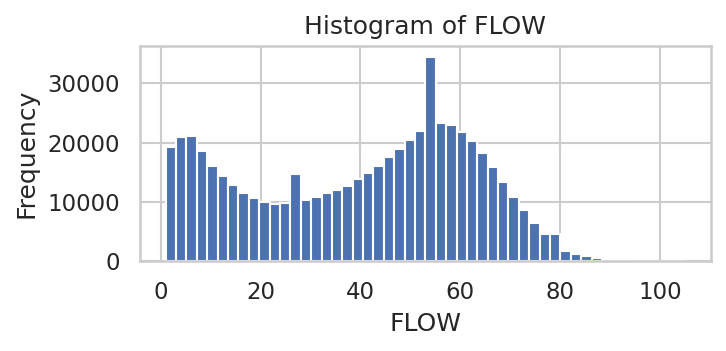

In [27]:
plt.figure(figsize=(5,2.5))
pm["FLOW"].dropna().plot(kind="hist", bins=50)
plt.xlabel("FLOW")
plt.title("Histogram of FLOW")
plt.savefig("hist_flow.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

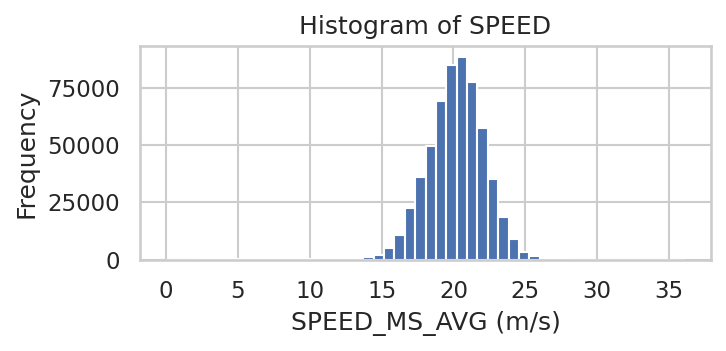

In [28]:
plt.figure(figsize=(5,2.5))
pm["SPEED_MS_AVG"].dropna().plot(kind="hist", bins=50)
plt.xlabel("SPEED_MS_AVG (m/s)")
plt.title("Histogram of SPEED")
plt.savefig("hist_speed.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

### Temporal Analysis

In [29]:
def add_time_cols(df: pd.DataFrame) -> pd.DataFrame:
  d = df.copy()
  d["year"] = d["datetime"].dt.year
  d["month"] = d["datetime"].dt.month
  d["day"] = d["datetime"].dt.day
  d["hour"] = d["datetime"].dt.hour
  d["minute"] = d["datetime"].dt.minute
  d["dow"] = d["datetime"].dt.dayofweek
  d["is_weekend"] = (d["dow"] >= 5)
  return d

In [30]:
def temporal_analysis(df:pd.DataFrame):
  d = add_time_cols(df)

  # Minute-level intraday average curve (FLOW)
  flow_minute = d.dropna(subset=["FLOW"]).groupby(["hour","minute"])["FLOW"].mean().reset_index()
  flow_minute["tminute"] = flow_minute["hour"]*60 + flow_minute["minute"]

  plt.figure(figsize=(6,2.2))
  plt.plot(flow_minute["tminute"], flow_minute["FLOW"], linewidth=1.0)
  plt.xticks([240,300,360,420,480,540,600], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Flow (mean)")
  plt.title("Minute-level average FLOW")
  plt.savefig("minute_level_flow.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Minute-level intraday average curve (SPEED)
  speed_minute = d.dropna(subset=["SPEED_MS_AVG"]).groupby(["hour","minute"])["SPEED_MS_AVG"].mean().reset_index()
  speed_minute["tminute"] = speed_minute["hour"]*60 + speed_minute["minute"]
  plt.figure(figsize=(6,2.2))
  plt.plot(speed_minute["tminute"], speed_minute["SPEED_MS_AVG"], linewidth=1.0)
  plt.xticks([240,300,360,420,480,540,600], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Speed (m/s, mean)")
  plt.title("Minute-level average SPEED")
  plt.savefig("minute_level_speed", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Hour-level intraday average curve (FLOW)
  flow_hour = d.dropna(subset=["FLOW"]).groupby(["hour"])["FLOW"].mean().reset_index()
  plt.figure(figsize=(6,2.2))
  plt.plot(flow_hour["hour"], flow_hour["FLOW"], marker="o", linewidth=1.0)
  plt.xticks([4,5,6,7,8,9,10], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Flow (mean)")
  plt.title("Hour-level average FLOW")
  plt.tight_layout()

  # Hour-level intraday average curve (SPEED)
  speed_hour = d.dropna(subset=["SPEED_MS_AVG"]).groupby(["hour"])["SPEED_MS_AVG"].mean().reset_index()
  plt.figure(figsize=(6,2.2))
  plt.plot(speed_hour["hour"], speed_hour["SPEED_MS_AVG"], marker="o", linewidth=1.0)
  plt.xticks([4,5,6,7,8,9,10], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Speed (m/s, mean)")
  plt.title("Hour-level average SPEED")
  plt.tight_layout()

  ### Distinguish between weekdays and weekends
  # Minute-level intraday average curve (FLOW)
  wd = d[~d["is_weekend"]]
  we = d[d["is_weekend"]]

  flow_minute_wd = wd.dropna(subset=["FLOW"]).groupby(["hour","minute"])["FLOW"].mean().reset_index()
  flow_minute_wd["tminute"] = flow_minute_wd["hour"]*60 + flow_minute_wd["minute"]

  flow_minute_we = we.dropna(subset=["FLOW"]).groupby(["hour","minute"])["FLOW"].mean().reset_index()
  flow_minute_we["tminute"] = flow_minute_we["hour"]*60 + flow_minute_we["minute"]

  plt.figure(figsize=(6,2.2))
  plt.plot(flow_minute_wd["tminute"], flow_minute_wd["FLOW"], linewidth=1.0, label="weekday")
  plt.plot(flow_minute_we["tminute"], flow_minute_we["FLOW"], linewidth=1.0, label="weekend")
  plt.xticks([240,300,360,420,480,540,600], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Flow (mean)")
  plt.title("Minute-level average FLOW: Weekday vs Weekend")
  plt.legend()
  plt.savefig("flow_weekday_weekend.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Minute-level intraday average curve (SPEED)
  flow_minute_wd = wd.dropna(subset=["SPEED_MS_AVG"]).groupby(["hour","minute"])["SPEED_MS_AVG"].mean().reset_index()
  flow_minute_wd["tminute"] = flow_minute_wd["hour"]*60 + flow_minute_wd["minute"]

  flow_minute_we = we.dropna(subset=["SPEED_MS_AVG"]).groupby(["hour","minute"])["SPEED_MS_AVG"].mean().reset_index()
  flow_minute_we["tminute"] = flow_minute_we["hour"]*60 + flow_minute_we["minute"]

  plt.figure(figsize=(6,2.2))
  plt.plot(flow_minute_wd["tminute"], flow_minute_wd["SPEED_MS_AVG"], linewidth=1.0, label="weekday")
  plt.plot(flow_minute_we["tminute"], flow_minute_we["SPEED_MS_AVG"], linewidth=1.0, label="weekend")
  plt.xticks([240,300,360,420,480,540,600], ["04:00","05:00","06:00","07:00","08:00","09:00","10:00"], rotation=0)
  plt.xlabel("Time of day")
  plt.ylabel("Speed (m/s, mean)")
  plt.title("Minute-level average SPEED: Weekday vs. Weekend")
  plt.legend()
  plt.savefig("speed_weekday_weekend.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Weakly Heatmap
  piv_flow = d.pivot_table(index="dow", columns="hour", values="FLOW", aggfunc="mean")
  piv_speed = d.pivot_table(index="dow", columns="hour", values="SPEED_MS_AVG", aggfunc="mean")
  plt.figure(figsize=(6.5,2.5))
  sns.heatmap(piv_flow, cmap="viridis", cbar_kws={"label":"FLOW mean"})
  plt.title("Week-Hour heatmap (FLOW)"); plt.xlabel("Hour"); plt.ylabel("Day of Week (0=Mon)")
  plt.savefig("flow_heatmap.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()
  plt.figure(figsize=(6.5,2.5))
  sns.heatmap(piv_speed, cmap="viridis", cbar_kws={"label":"Speed mean (m/s)"})
  plt.title("Weekly-Hour heatmap (SPEED)"); plt.xlabel("Hour"); plt.ylabel("Day of Week (0=Mon)")
  plt.savefig("speed_heatmap.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Monthly
  flow_month = d.dropna(subset=["FLOW"]).groupby(["year","month"])["FLOW"].mean().reset_index()
  flow_month["ym"] = flow_month["year"].astype("str") + "-" + flow_month["month"].astype("str")

  plt.figure(figsize=(6,2.2))
  plt.plot(flow_month["ym"], flow_month["FLOW"], linewidth=1.0)
  plt.xticks(rotation=0)
  plt.xlabel("Month")
  plt.ylabel("Flow (mean)")
  plt.title("Monthly average FLOW")
  plt.tight_layout()

  speed_month = d.dropna(subset=["SPEED_MS_AVG"]).groupby(["year","month"])["SPEED_MS_AVG"].mean().reset_index()
  speed_month["ym"] = speed_month["year"].astype("str") + "-" + speed_month["month"].astype("str")
  plt.figure(figsize=(6,2.2))
  plt.plot(speed_month["ym"], speed_month["SPEED_MS_AVG"], linewidth=1.0)
  plt.xticks(rotation=0)
  plt.xlabel("Month")
  plt.ylabel("Speed (m/s, mean)")
  plt.title("Monthly average SPEED")
  plt.tight_layout()

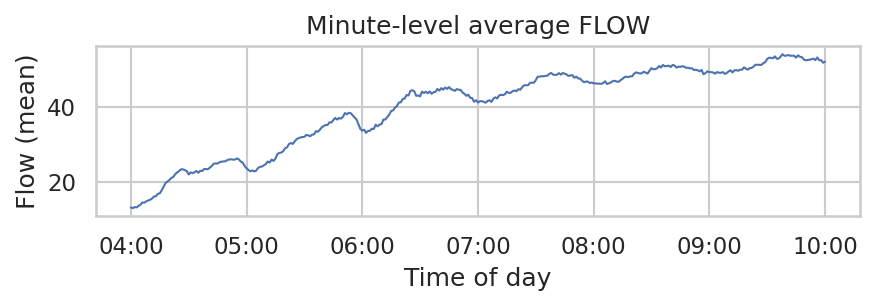

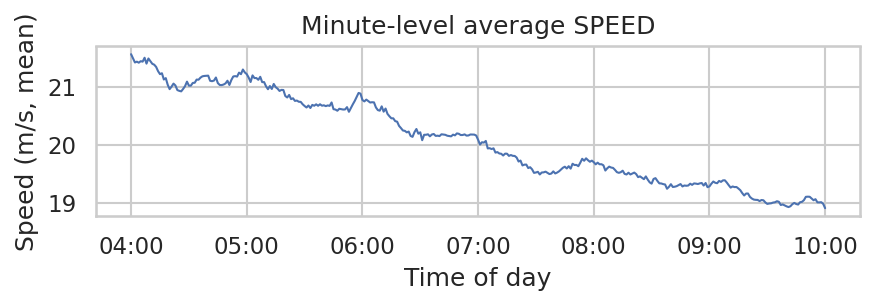

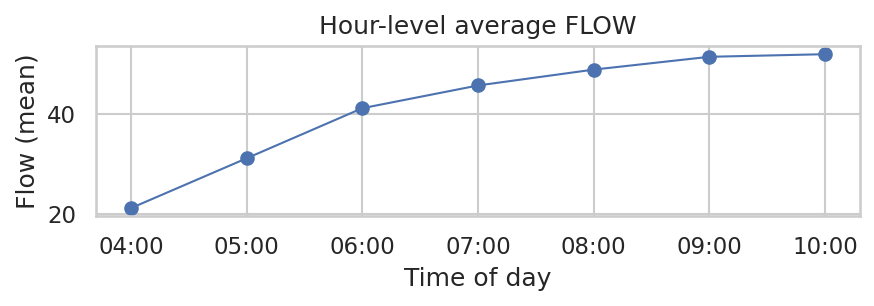

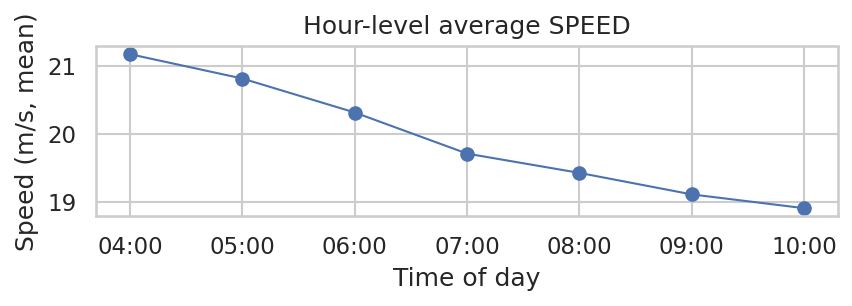

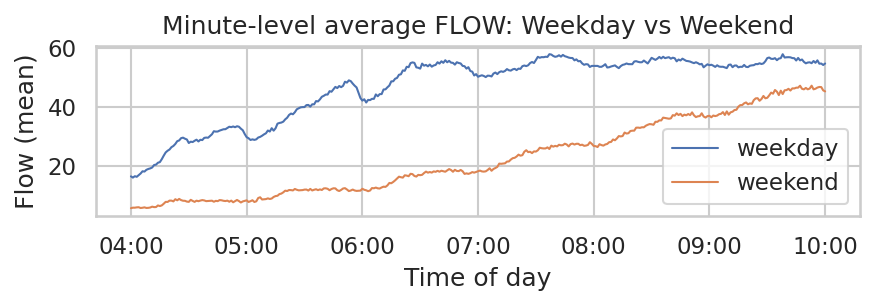

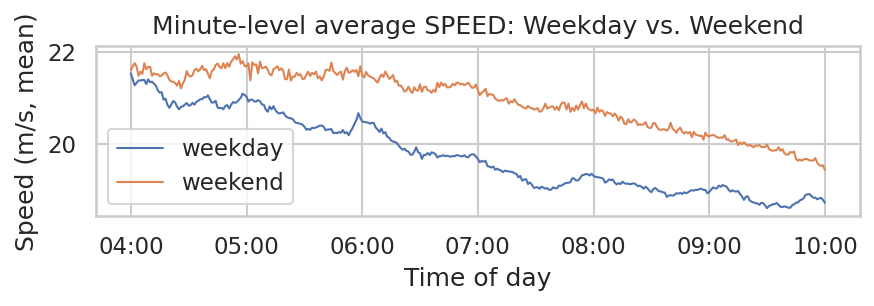

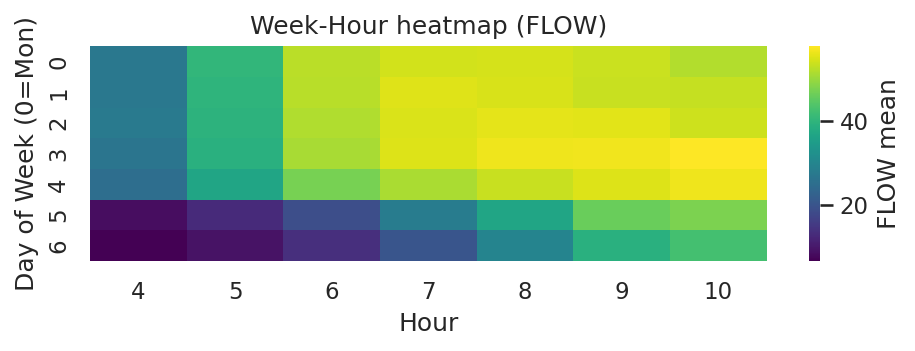

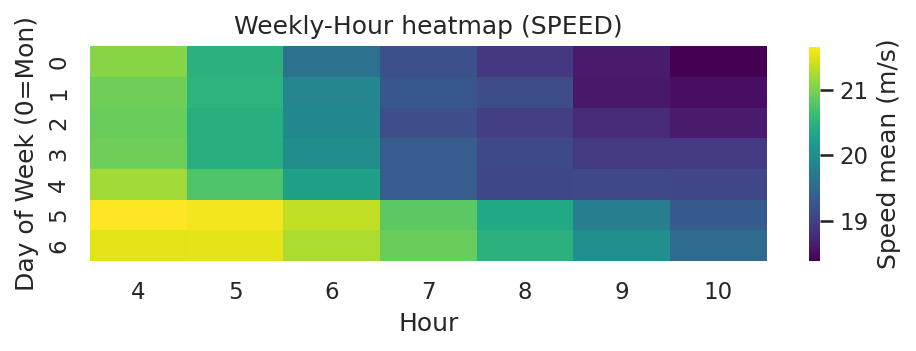

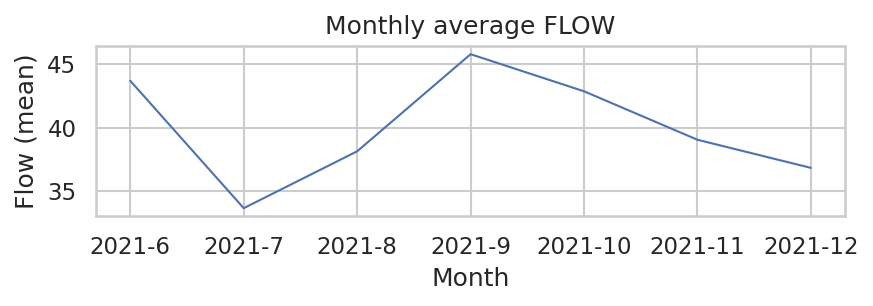

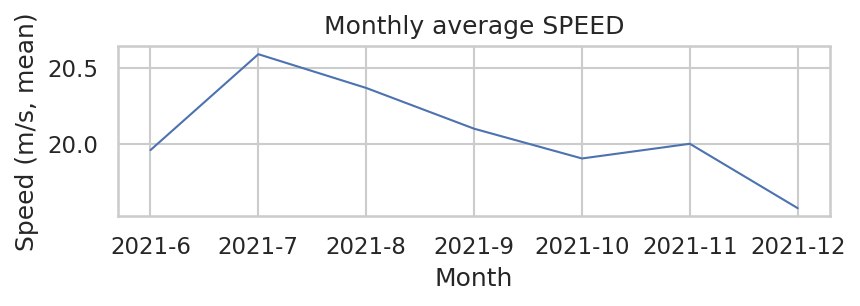

In [31]:
temporal_analysis(pm)

### Spatial Analysis

In [32]:
def spatial_analysis(df:pd.DataFrame):
  d = df.copy()

  # Flow by portal
  plt.figure(figsize=(7,6))
  plt.subplot(2,1,1)
  sns.boxplot(data=d.dropna(subset=["FLOW"]), x="PORTAL", y="FLOW", fliersize=1)
  plt.title("FLOW by PORTAL")
  plt.xlabel("")
  plt.ylabel("Flow (mean)")
  plt.xticks(rotation=30, ha="right")
  plt.savefig("flow_portal.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Speed by portal
  plt.subplot(2,1,2)
  sns.boxplot(data=d.dropna(subset=["SPEED_MS_AVG"]), x="PORTAL", y="SPEED_MS_AVG", fliersize=1)
  plt.title("SPEED by PORTAL")
  plt.xlabel(" ")
  plt.ylabel("Speed (m/s, mean)")
  plt.xticks(rotation=30, ha="right")
  plt.savefig("speed_portal.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  # Consider downstreams and upstreams
  portal_ids = ["E4S 55,620", "E4S 56,160", "E4S 56,490", "E4S 56,780",
          "E4S 57,055", "E4S 57,435", "E4S 57,820", "E4S 58,140"]

  flow_portal = d.dropna(subset=["FLOW"]).groupby("PORTAL")["FLOW"].mean().reindex(portal_ids)
  plt.figure(figsize=(6.5,2.2))
  plt.plot(flow_portal.index, flow_portal.values, marker="o")
  plt.title("FLOW gradient along river (downstream → upstream)")
  plt.xticks(rotation=30, ha="right")
  plt.ylabel("FLOW mean")
  plt.tight_layout()

  speed_portal = d.dropna(subset=["SPEED_MS_AVG"]).groupby("PORTAL")["SPEED_MS_AVG"].mean().reindex(portal_ids)
  plt.figure(figsize=(6.5,2.2))
  plt.plot(speed_portal.index, speed_portal.values, marker="o")
  plt.title("SPEED gradient along river (downstream → upstream)")
  plt.xticks(rotation=30, ha="right")
  plt.ylabel("Speed mean (m/s)")
  plt.tight_layout()
  # Results from these two graphs can be obtained from boxplots, so can delete these two line charts

  #
  pivot_flow = d.pivot_table(index="datetime", columns="PORTAL", values="FLOW", aggfunc="mean")
  pivot_speed = d.pivot_table(index="datetime", columns="PORTAL", values="SPEED_MS_AVG", aggfunc="mean")

  corr_flow = pivot_flow.corr()
  corr_speed = pivot_speed.corr()

  plt.figure(figsize=(5,4))
  sns.heatmap(corr_flow, cmap="coolwarm", vmin=-1, vmax=1, square=True)
  plt.title("Correlation matrix (FLOW)")
  plt.savefig("flow_cmatrix.png", dpi=300, bbox_inches="tight")
  plt.tight_layout()

  plt.figure(figsize=(5,4))
  sns.heatmap(corr_speed, cmap="coolwarm", vmin=-1, vmax=1, square=True)
  plt.title("Correlation matrix (SPEED)")
  plt.savefig("speed_cmatrix.png", dpi=300, bbox_inches="tight")
  plt.tight_layout();

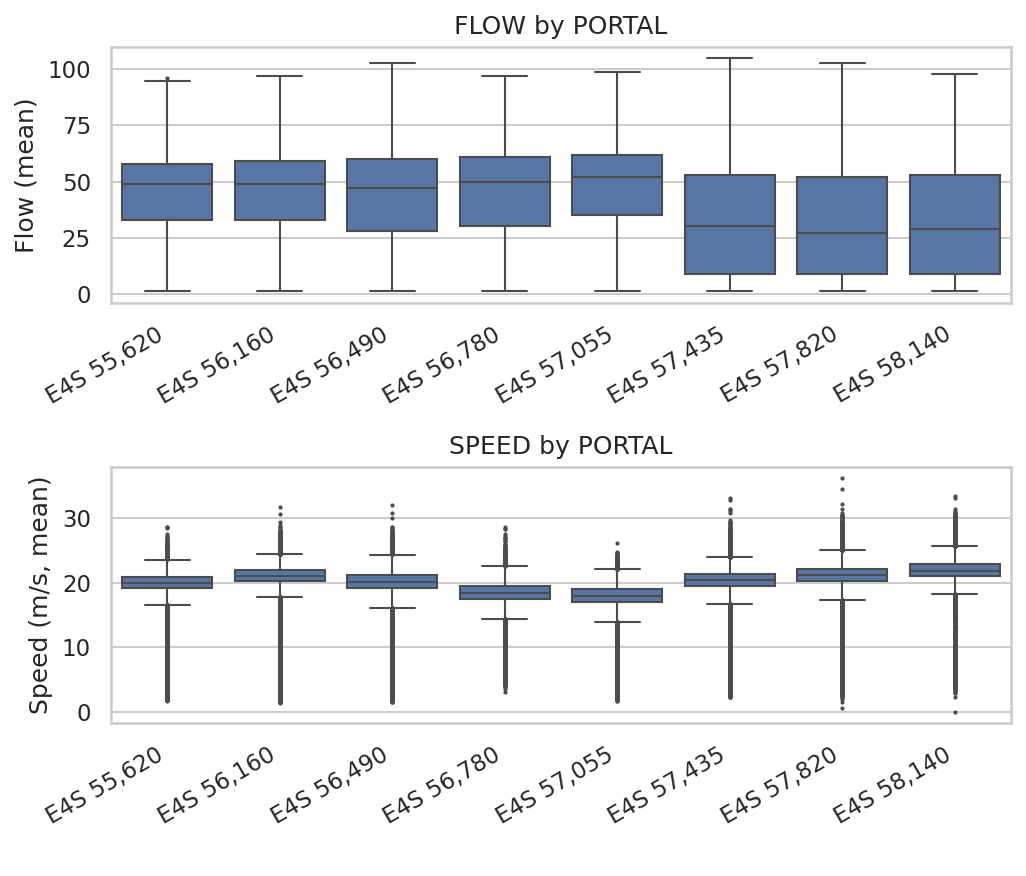

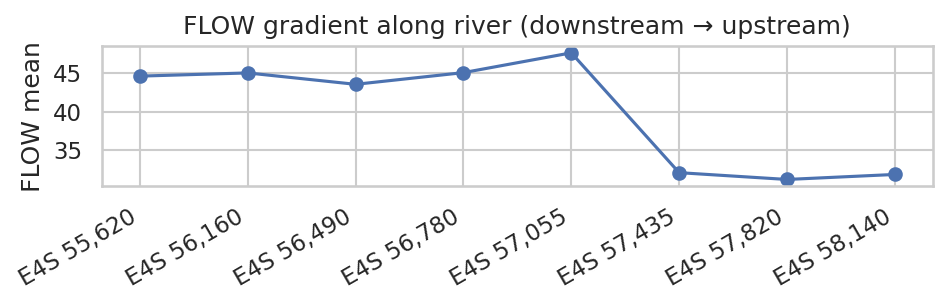

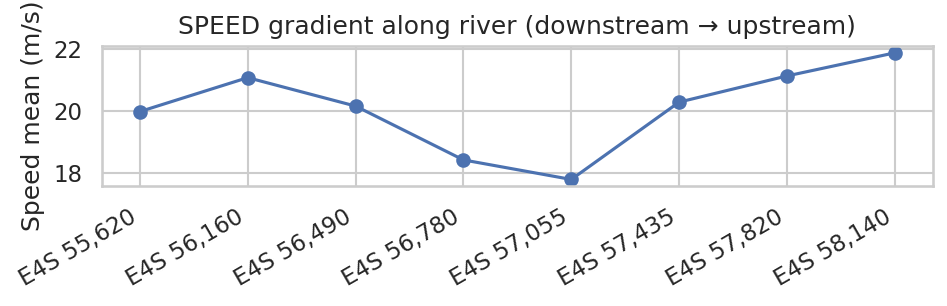

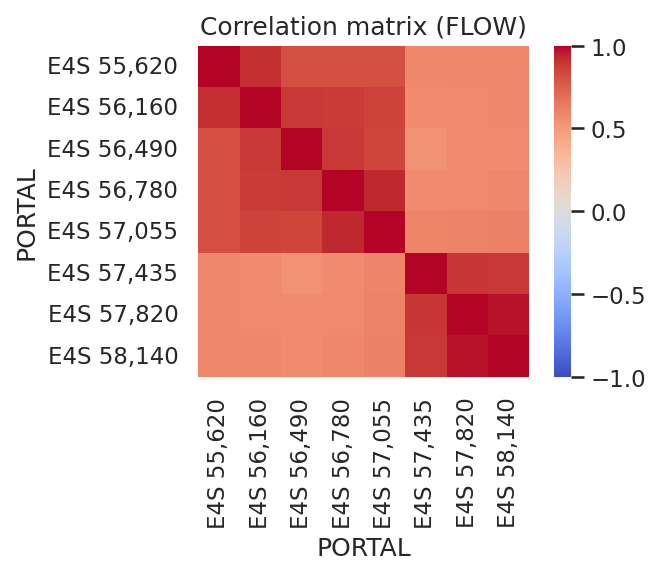

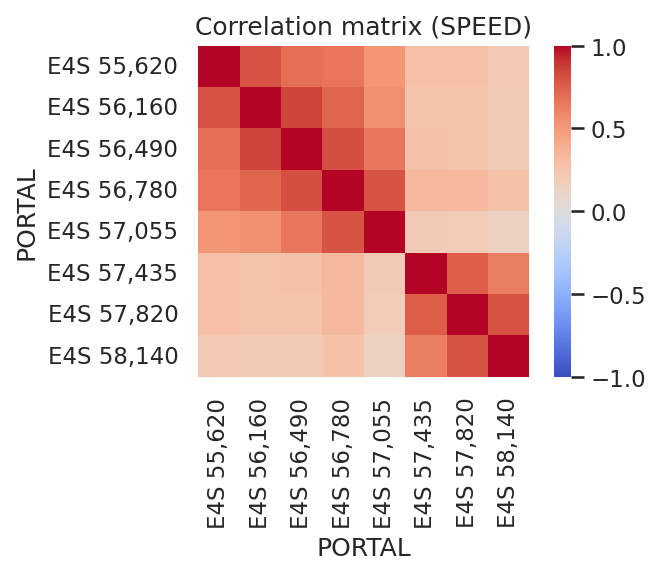

In [33]:
spatial_analysis(pm)

## Handling Missing Values

In [34]:
df = portal_minute.sort_values(["PORTAL","datetime"]).copy()

# split training and validation set
VAL_START = pd.Timestamp("2021-12-01 04:00:00")
VAL_END = pd.Timestamp("2021-12-31 10:00:00")

train_df = df[df["datetime"] < VAL_START]
val_df = df[(df["datetime"] >= VAL_START) & (df["datetime"] <= VAL_END)]
test_df = portal_minute_test.sort_values(["PORTAL","datetime"]).copy()

# calculate statistics on training set (in order to avoid information leakage)
train_df["Hour"] = train_df["datetime"].dt.hour
train_df["Minute"] = train_df["datetime"].dt.minute
# same portal same hour & minute: flow & speed median
train_pt_flow = train_df.groupby(["PORTAL","Hour","Minute"])["FLOW"].median()
train_pt_speed = train_df.groupby(["PORTAL","Hour","Minute"])["SPEED_MS_AVG"].median()

# first fill with train_df
train_df.set_index("datetime", inplace=True)
train_df["SPEED_MS_AVG"] = (train_df.groupby("PORTAL")["SPEED_MS_AVG"]
                   .transform(lambda s: s.interpolate(method="time", limit=2))
)
train_df.reset_index(inplace=True)

train_df = train_df.merge(train_pt_speed, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
train_df["SPEED_MS_AVG"] = train_df["SPEED_MS_AVG"].fillna(train_df["SPEED_MS_AVG_median"])

train_df = train_df.merge(train_pt_flow, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
train_df["FLOW"] = train_df["FLOW"].fillna(train_df["FLOW_median"])
train_df["FLOW"] = train_df["FLOW"].fillna(0.0)

# Speed: time-based interpolation within each PORTAL for short gaps(<=2 mins)
val_df.set_index("datetime",inplace=True)
val_df["SPEED_MS_AVG"] = (val_df.groupby("PORTAL")["SPEED_MS_AVG"]
                 .transform(lambda s: s.interpolate(method="time", limit=2)))
val_df.reset_index(inplace=True)

test_df.set_index("datetime",inplace=True)
test_df["SPEED_MS_AVG"] = (test_df.groupby("PORTAL")["SPEED_MS_AVG"]
                 .transform(lambda s: s.interpolate(method="time", limit=2)))
test_df.reset_index(inplace=True)

# Speed: for remaining nans, fill the historical median of training set at the same portal and same time
val_df["Hour"] = val_df["datetime"].dt.hour
val_df["Minute"] = val_df["datetime"].dt.minute
val_df = val_df.merge(train_pt_speed, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
val_df["SPEED_MS_AVG"] = val_df["SPEED_MS_AVG"].fillna(val_df["SPEED_MS_AVG_median"])

test_df["Hour"] = test_df["datetime"].dt.hour
test_df["Minute"] = test_df["datetime"].dt.minute
test_df = test_df.merge(train_pt_speed, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
test_df["SPEED_MS_AVG"] = test_df["SPEED_MS_AVG"].fillna(test_df["SPEED_MS_AVG_median"])

# Flow: first, fill the historical median of training set at the same portal and same time
val_df = val_df.merge(train_pt_flow, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
val_df["FLOW"] = val_df["FLOW"].fillna(val_df["FLOW_median"])

test_df = test_df.merge(train_pt_flow, on=["PORTAL","Hour","Minute"], how="left", suffixes=("", "_median"))
test_df["FLOW"] = test_df["FLOW"].fillna(test_df["FLOW_median"])

# Flow: for remaining nans, fill 0
val_df["FLOW"] = val_df["FLOW"].fillna(0.0)
test_df["FLOW"] = test_df["FLOW"].fillna(0.0)

val_df.drop(["Hour","Minute","SPEED_MS_AVG_median","FLOW_median"],axis=1,inplace=True)
test_df.drop(["Hour","Minute","SPEED_MS_AVG_median","FLOW_median"],axis=1,inplace=True)
train_df.drop(["Hour","Minute","SPEED_MS_AVG_median","FLOW_median"],axis=1,inplace=True)

/tmp/ipython-input-3040424117.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Hour"] = train_df["datetime"].dt.hour
/tmp/ipython-input-3040424117.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Minute"] = train_df["datetime"].dt.minute
/tmp/ipython-input-3040424117.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [35]:
train_df.to_csv("train_df.csv",index=False)
val_df.to_csv("val_df.csv",index=False)
test_df.to_csv("test_df.csv",index=False)

## Descriptive Analysis (After Imputation/Verify the rationality of interpolation）

In [36]:
pm_filled = pd.concat([train_df, val_df])

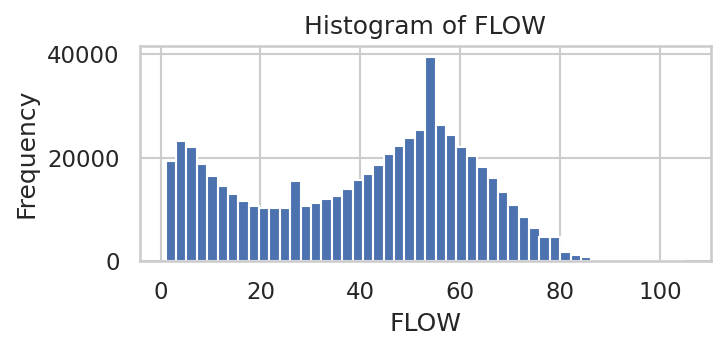

In [37]:
plt.figure(figsize=(5,2.5))
pm_filled["FLOW"].plot(kind="hist", bins=50)
plt.xlabel("FLOW")
plt.title("Histogram of FLOW")
plt.tight_layout()

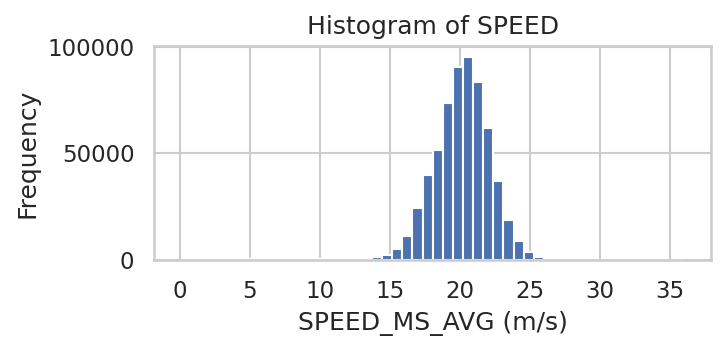

In [38]:
plt.figure(figsize=(5,2.5))
pm_filled["SPEED_MS_AVG"].plot(kind="hist", bins=50)
plt.xlabel("SPEED_MS_AVG (m/s)")
plt.title("Histogram of SPEED")
plt.tight_layout()

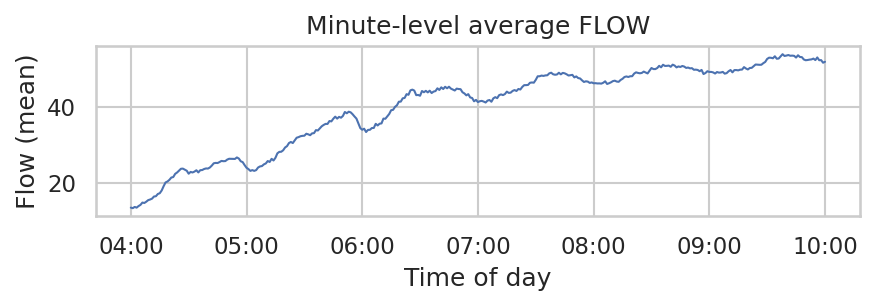

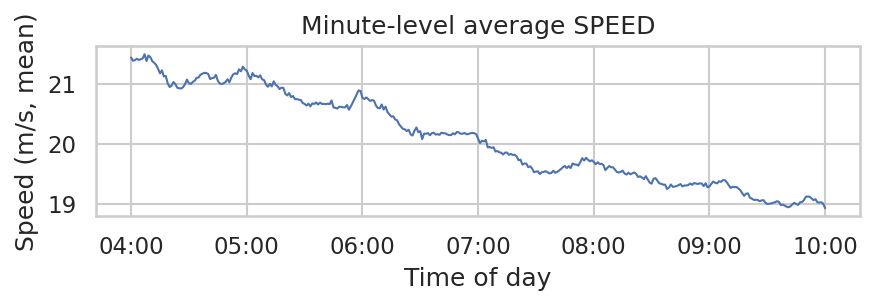

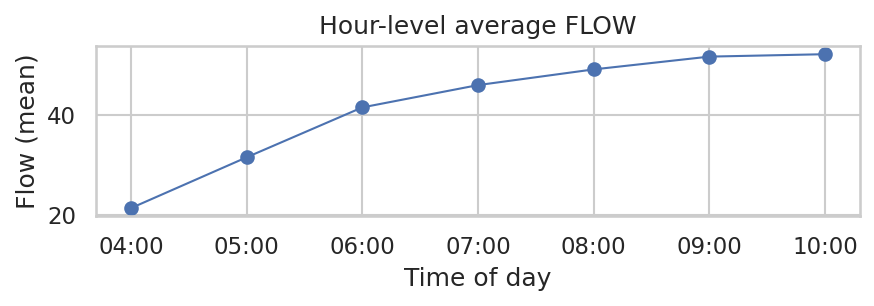

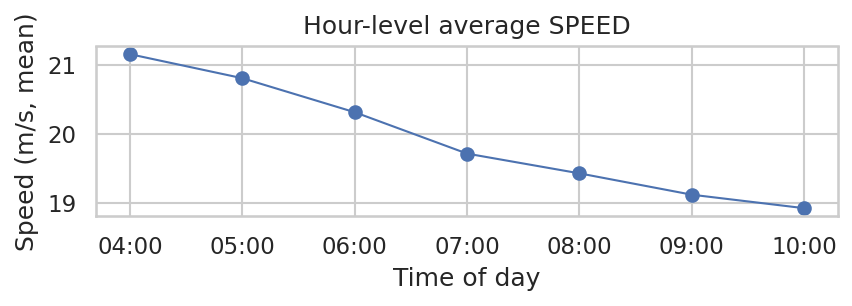

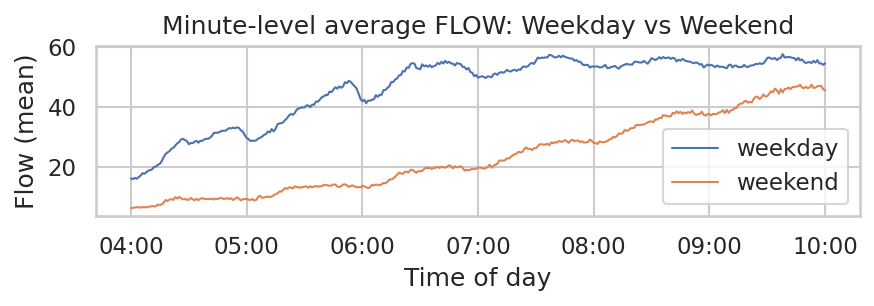

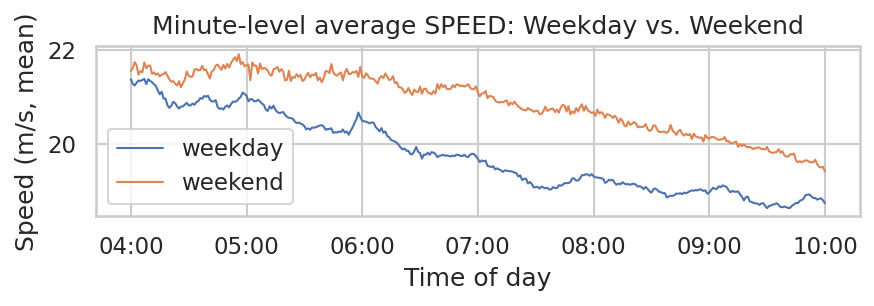

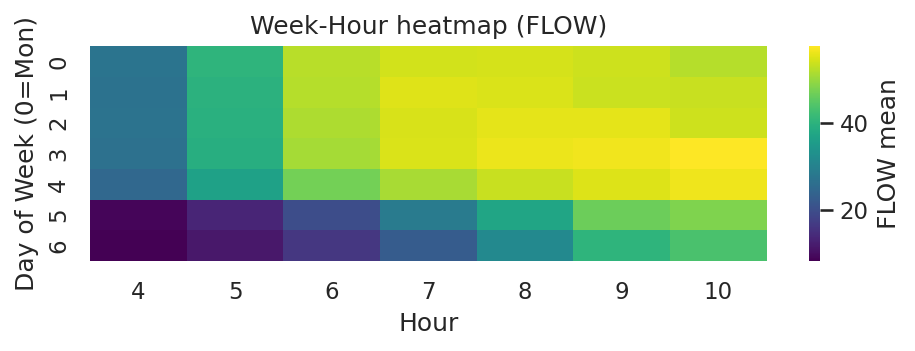

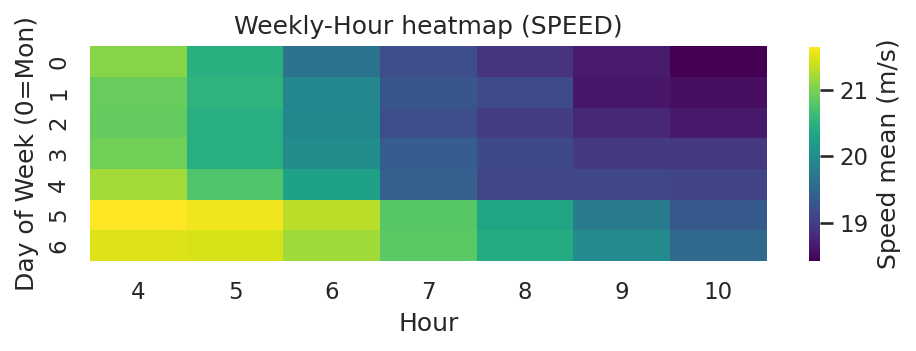

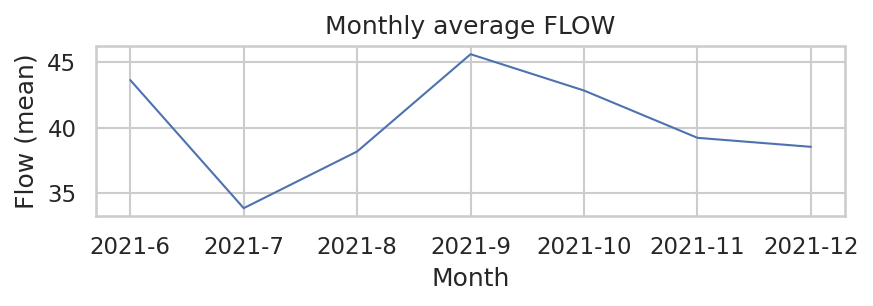

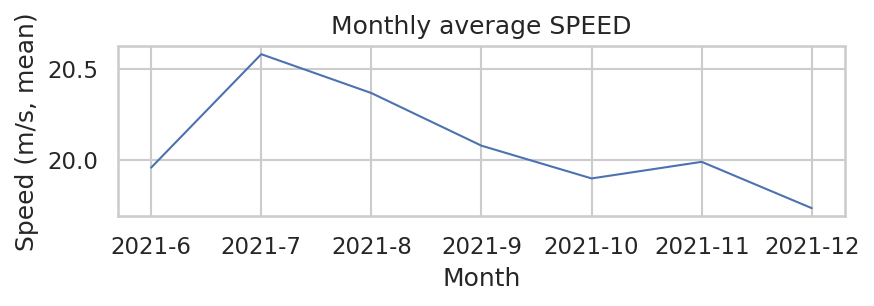

In [39]:
temporal_analysis(pm_filled)

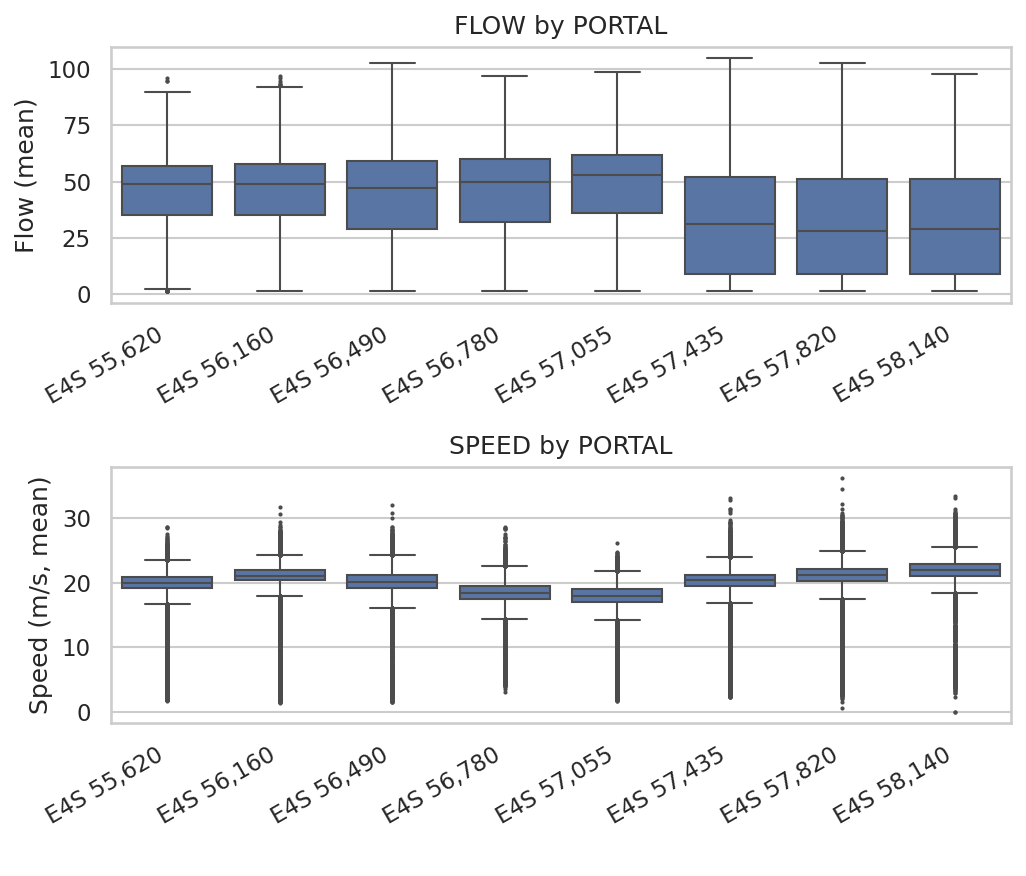

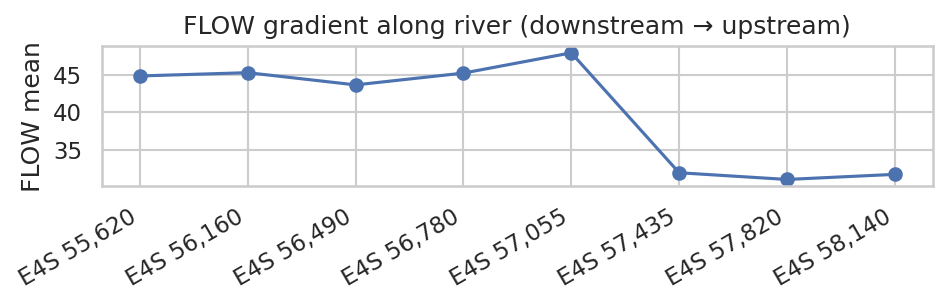

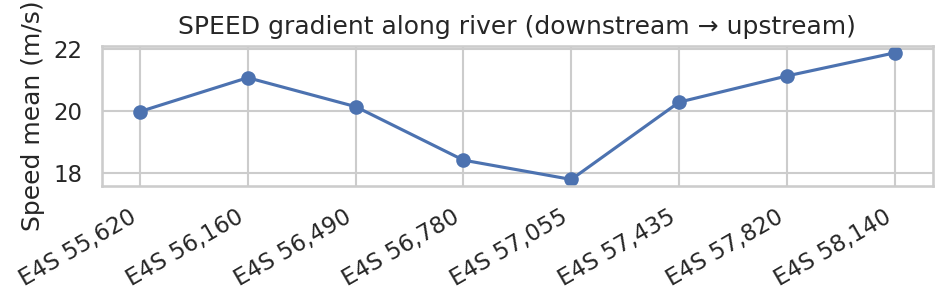

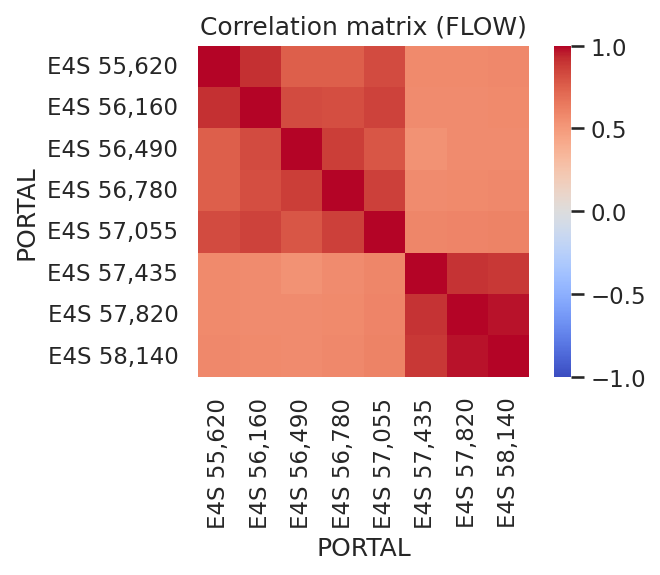

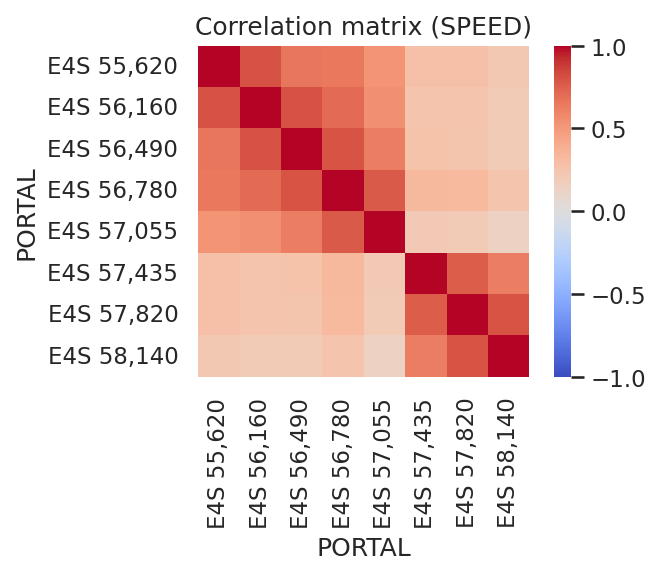

In [40]:
spatial_analysis(pm_filled)

## Help Functions

#### **Setup device agnostic code**

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### **Create a function to Time our experiments**

In [3]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = device):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

#### **Functionize the training and test loop**

In [4]:
def train_step(model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn:torch.nn.Module,
        optimizer:torch.optim.Optimizer,
        device:torch.device=device):

  train_loss = 0
  model.to(device)
  model.train()

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lstm_all.parameters(), 1.0)
    optimizer.step()

  train_loss /= len(data_loader)

  print(f"Train loss: {train_loss:.5f}")
  return train_loss


def test_step(model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn:torch.nn.Module,
        device:torch.device=device):

  test_loss = 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y).item()

    test_loss /= len(data_loader)

  print(f"Test loss: {test_loss:.5f}")
  return test_loss

#### **Functionize Evaluation**

In [5]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

def eval_model(model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device: torch.device = device,
        scaler=None,
        horizons:list=None,
        feature_names:list=None):

    model.to(device)
    model.eval()

    y_true_list = []
    y_pred_list= []
    loss = 0

    with torch.inference_mode():
      for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss += loss_fn(y_pred, y).item()
        y_true_list.append(y.cpu().numpy())
        y_pred_list.append(y_pred.cpu().numpy())


    loss /= len(data_loader)

    metrics = {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss}

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    # inverse tranform
    if scaler is not None:
      if y_true.ndim ==3:  # [N,H,D]
        N, H, D = y_true.shape
        y_true_inv = scaler.inverse_transform(y_true.reshape(-1,D)).reshape(N,H,D)
        y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,D)).reshape(N,H,D)
      else:
        N, H = y_true.shape  # [N,H]
        y_true_inv = scaler.inverse_transform(y_true.reshape(-1,1)).reshape(N,H)
        y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1)).reshape(N,H)
    else:
      y_true_inv, y_pred_inv = y_true, y_pred

    # metrics
    if y_true_inv.ndim == 3:
      N, H, D = y_true_inv.shape
      fnames = feature_names[:D]

      # overall
      metrics["MAE_overall"] = mean_absolute_error(y_true_inv.ravel(), y_pred_inv.ravel())
      metrics["RMSE_overall"] = root_mean_squared_error(y_true_inv.ravel(), y_pred_inv.ravel())

      # per feature (flow / speed)
      metrics["MAE_per_feature"] = {fnames[i]: mean_absolute_error(y_true_inv[:,:,i].ravel(), y_pred_inv[:,:,i].ravel()) for i in range(D)}
      metrics["RMSE_per_feature"] = {fnames[i]: root_mean_squared_error(y_true_inv[:,:,i].ravel(), y_pred_inv[:,:,i].ravel()) for i in range(D)}

      # per step (range(horizons))
      mae_per_step  = [mean_absolute_error(y_true_inv[:,i-1,:].ravel(), y_pred_inv[:,i-1,:].ravel()) for i in horizons]
      rmse_per_step = [root_mean_squared_error(y_true_inv[:,i-1,:].ravel(), y_pred_inv[:,i-1,:].ravel()) for i in horizons]
      metrics["MAE_per_step"]  = dict(zip(horizons, mae_per_step))
      metrics["RMSE_per_step"] = dict(zip(horizons, rmse_per_step))

      # —— Aggregate column names with portal into basic features (FLOW/SPEED.MS.AVG) ——
      def _base_feat(name: str):
        if name.startswith("FLOW"):
          return "FLOW"
        if name.startswith("SPEED_MS_AVG") or name.startswith("SPEED"):
          return "SPEED_MS_AVG"
          return name.split("_")[0]

      groups = {}  # {'FLOW': [j1,j2,...], 'SPEED_MS_AVG': [k1,k2,...]}
      for j, name in enumerate(fnames):
        groups.setdefault(_base_feat(name), []).append(j)

      # —— Calculate MAE/RMSE for 'By Feature x By Step (Summarize All Portals) ——
      mae_fps, rmse_fps = {}, {}
      rows = []
      for feat, js in groups.items():
        mae_fps[feat], rmse_fps[feat] = {}, {}
        for idx, h in enumerate(horizons):
          yt = np.concatenate([y_true_inv[:, idx, j].ravel() for j in js])
          yp = np.concatenate([y_pred_inv[:, idx, j].ravel() for j in js])
          mae_v  = mean_absolute_error(yt, yp)
          rmse_v = root_mean_squared_error(yt, yp)

          mae_fps[feat][h]  = mae_v
          rmse_fps[feat][h] = rmse_v
          rows.append({"feature": feat, "horizon": h, "MAE": mae_v, "RMSE": rmse_v})

      metrics["MAE_per_feature_per_step"]  = mae_fps
      metrics["RMSE_per_feature_per_step"] = rmse_fps
      metrics["per_step_df"] = pd.DataFrame(rows)

    else:  # [N,H]
      N, H = y_true_inv.shape
      mae_per_step  = [mean_absolute_error(y_true_inv[:,i-1].ravel(), y_pred_inv[:,i-1].ravel()) for i in horizons]
      rmse_per_step = [root_mean_squared_error(y_true_inv[:,i-1].ravel(), y_pred_inv[:,i-1].ravel()) for i in horizons]

      mae_mean  = np.mean(mae_per_step)
      rmse_mean = np.mean(rmse_per_step)

      metrics.update({
            "MAE_mean": mae_mean,
            "RMSE_mean": rmse_mean,
            "MAE_per_step": mae_per_step,
            "RMSE_per_step": rmse_per_step,
      })

    return metrics, y_true_inv, y_pred_inv

## All-Portals LSTM

In [6]:
class SimpleLSTM(nn.Module):
  def __init__(self,
         input_size=2,   # 2 features: flow and speed
         hidden_size=64,
         num_layers=1,
         horizon=15,    # prediction_length: len(HORIZIONS)
         out_size=2):    # 2 predict features: flow and speed

    super().__init__()
    self.horizon=horizon
    self.out_size=out_size

    self.lstm = nn.LSTM(input_size=input_size,
               hidden_size=hidden_size,
               num_layers=num_layers,
               batch_first=True)

    self.linear = nn.Linear(in_features=hidden_size,
                 out_features=horizon*out_size)

  def forward(self,x):
    """
      x: [batch_size, seq_len, input_size],

      return: [batch_size, horizon, out_size]
    """

    lstm_out, (h_n,c_n) = self.lstm(x)
    output = self.linear(lstm_out[:,-1,:])   # many to one

    return output.view(-1,self.horizon,self.out_size)

In [7]:
train_df = pd.read_csv("train_df.csv")
val_df = pd.read_csv("val_df.csv")
test_df = pd.read_csv("test_df.csv")
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
val_df["datetime"] = pd.to_datetime(val_df["datetime"])
test_df["datetime"] = pd.to_datetime(test_df["datetime"])

In [8]:
train_df.sort_values(["datetime","PORTAL"], inplace=True)
train_flow = train_df.pivot(index="datetime", columns="PORTAL", values="FLOW").add_prefix("FLOW_")
train_speed = train_df.pivot(index="datetime", columns="PORTAL", values="SPEED_MS_AVG").add_prefix("SPEED_")
train_flow_speed = pd.concat([train_flow, train_speed], axis=1)

portal_ids = ["E4S 55,620", "E4S 56,160", "E4S 56,490", "E4S 56,780",
        "E4S 57,055", "E4S 57,435", "E4S 57,820", "E4S 58,140"]
feature_cols = []
for pid in portal_ids:
  for col in (f"FLOW_{pid}", f"SPEED_{pid}"):
    feature_cols.append(col)

train_flow_speed = train_flow_speed[feature_cols]

In [9]:
val_df.sort_values(["datetime","PORTAL"], inplace=True)
val_flow = val_df.pivot(index="datetime", columns="PORTAL", values="FLOW").add_prefix("FLOW_")
val_speed = val_df.pivot(index="datetime", columns="PORTAL", values="SPEED_MS_AVG").add_prefix("SPEED_")
val_flow_speed = pd.concat([val_flow, val_speed], axis=1)
val_flow_speed = val_flow_speed[feature_cols]

In [10]:
test_df.sort_values(["datetime","PORTAL"], inplace=True)
test_flow = test_df.pivot(index="datetime", columns="PORTAL", values="FLOW").add_prefix("FLOW_")
test_speed = test_df.pivot(index="datetime", columns="PORTAL", values="SPEED_MS_AVG").add_prefix("SPEED_")
test_flow_speed = pd.concat([test_flow, test_speed], axis=1)
test_flow_speed = test_flow_speed[feature_cols]

In [11]:
train_flow_speed.shape, val_flow_speed.shape, test_flow_speed.shape

((66063, 16), (11191, 16), (65341, 16))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.06283
Test loss: 0.05305
Epoch: 1
---------
Train loss: 0.05226
Test loss: 0.05140
Epoch: 2
---------
Train loss: 0.05161
Test loss: 0.05096
Epoch: 3
---------
Train loss: 0.05110
Test loss: 0.05293
Epoch: 4
---------
Train loss: 0.05068
Test loss: 0.05036
Epoch: 5
---------
Train loss: 0.05032
Test loss: 0.05028
Epoch: 6
---------
Train loss: 0.05009
Test loss: 0.05111
Epoch: 7
---------
Train loss: 0.04990
Test loss: 0.05063
Epoch: 8
---------
Train loss: 0.04974
Test loss: 0.05126
Epoch: 9
---------
Train loss: 0.04960
Test loss: 0.05019
Epoch: 10
---------
Train loss: 0.04943
Test loss: 0.04954
Epoch: 11
---------
Train loss: 0.04930
Test loss: 0.05052
Epoch: 12
---------
Train loss: 0.04919
Test loss: 0.05104
Epoch: 13
---------
Train loss: 0.04911
Test loss: 0.05030
Epoch: 14
---------
Train loss: 0.04906
Test loss: 0.04873
Epoch: 15
---------
Train loss: 0.04897
Test loss: 0.05046
Epoch: 16
---------
Train loss: 0.04891
Test loss: 0.04993
Epoch: 

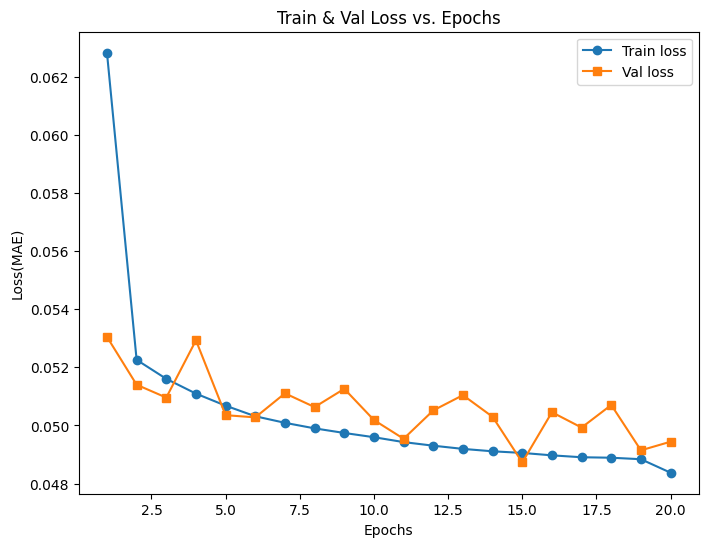

In [12]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import copy

HORIZONS = list(range(1,16))
LOOKBACK = 60
BATCH = 32
HIDDEN = 96
LR = 5e-4
WD = 1e-4
EPOCHS = 50

def make_dataset(data, lookback=60, horizons=None, stride=1):

    X, y = [], []
    max_h = max(horizons)
    for i in range(0, len(data)-lookback-max_h+1, stride):
      X.append(data[i:i+lookback,:])
      y.append(np.stack([data[i+lookback+h-1,:] for h in horizons], axis=0))
    return np.array(X, np.float32), np.array(y, np.float32)

# ======================================= Data Preparing =========================================================
train_data = train_flow_speed.values
val_data = val_flow_speed.values
test_data = test_flow_speed.values

scaler = MinMaxScaler((0,1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

X_train,y_train = make_dataset(train_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)
X_val,y_val = make_dataset(val_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)
X_test,y_test = make_dataset(test_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)

# transform numpy to tensor & float32
X_train = torch.from_numpy(X_train).float()   # [N,L,2*8]
y_train = torch.from_numpy(y_train).float()   # [N,H,2*8]
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(X_train,y_train)
val_dataset = TensorDataset(X_val,y_val)
test_dataset = TensorDataset(X_test,y_test)

train_dataloader = DataLoader(train_dataset,batch_size=BATCH,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH,shuffle=False)


# ====================== Instantiate a model & Set Loss Fcunction & Optimzier ==============================
D = train_flow_speed.shape[1]  # number of portals * 2 (two features: flow & speed)
lstm_all = SimpleLSTM(input_size=D, hidden_size=HIDDEN, num_layers=1, horizon=len(HORIZONS), out_size=D)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(lstm_all.parameters(),lr=LR,weight_decay=WD)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-6
)

# ===================== Training and test loop ==================================================================
train_losses, val_losses = [], []
best_val, best_state, wait = float("inf"), None, 0
patience_es = 5

start_time = timer()
for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n---------")
  train_loss = train_step(lstm_all,train_dataloader,loss_fn,optimizer,device)
  val_loss = test_step(lstm_all,val_dataloader,loss_fn,device)
  scheduler.step(val_loss)
  # print("current lr:", optimizer.param_groups[0]["lr"])

  train_losses.append(train_loss)
  val_losses.append(val_loss)     # for plot

  # Early Stopping
  if val_loss < best_val - 1e-6:
    best_val, best_state, wait = val_loss, copy.deepcopy(lstm_all.state_dict()), 0
  else:
    wait += 1
    if wait >= patience_es:
      print(f"Early stopping triggered at epoch {epoch}. Best val loss = {best_val:.5f}")
      break

if best_state is not None:
  lstm_all.load_state_dict(best_state)

end_time = timer()
total_time = print_train_time(start_time, end_time, device=device)

### Visualize
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, marker = "o", label="Train loss")
plt.plot(range(1, len(val_losses)+1), val_losses, marker = "s", label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss(MAE)")
plt.title("Train & Val Loss vs. Epochs")
plt.legend()
plt.show()

In [52]:
# torch.save(lstm_all.state_dict(), "lstm_model.pth")

In [13]:
# Final Test evaluation
metrics,y_true,y_pred = eval_model(model=lstm_all,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      device=device,
      scaler=scaler,
      horizons=HORIZONS,
      feature_names=feature_cols)
print(metrics["MAE_overall"], metrics["RMSE_overall"])
metrics["per_step_df"]

4.111081600189209 7.531502723693848


,feature,horizon,MAE,RMSE
0,FLOW,1,6.194353,8.558532
1,FLOW,2,6.558904,9.125039
2,FLOW,3,6.696329,9.411859
3,FLOW,4,6.796215,9.631489
4,FLOW,5,6.918030,9.856170
5,FLOW,6,7.080659,10.168416
6,FLOW,7,7.207977,10.395031
7,FLOW,8,7.347476,10.598905
8,FLOW,9,7.448575,10.804684
9,FLOW,10,7.562138,10.955216


In [14]:
metrics["per_step_df"].to_csv("lstm_evaluation_results.csv")

# GCN + LSTM

In [15]:
train_df = pd.read_csv("train_df.csv")
val_df = pd.read_csv("val_df.csv")
test_df = pd.read_csv("test_df.csv")
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
val_df["datetime"] = pd.to_datetime(val_df["datetime"])
test_df["datetime"] = pd.to_datetime(test_df["datetime"])

In [16]:
portal_ids = ["E4S 55,620", "E4S 56,160", "E4S 56,490", "E4S 56,780",
        "E4S 57,055", "E4S 57,435", "E4S 57,820", "E4S 58,140"]

In [17]:
def id_to_pos(pid: str) -> int:
  """
    Transform the numbers in the portal id into a "meter mark",
    for calculating distance later
  """
  s = pid.replace("E4S", "").replace(",", "")
  s = s.strip()
  return int(s)

In [18]:
pos = np.array([id_to_pos(p) for p in portal_ids], dtype=np.float32)
d_nn = np.abs(np.diff(pos))
# choose the 0.5*median of adjacent distances as sigma, for calculating Gaussian kernel (weighted adjacency)
median = np.median(d_nn)
sigma = median * 0.5
sigma

np.float32(165.0)

In [19]:
def weight_gaussian(d, sigma):
  """
    Gaussian kernel as weight function
  """
  return np.exp(-(d**2)/(2*sigma**2))

In [20]:
def build_Ahat(portal_ids, sigma, device:torch.device=device):

  N = len(portal_ids)
  pos = np.array([id_to_pos(p) for p in portal_ids], dtype=np.float32)
  order = np.argsort(-pos)

  # build an adjacency matrix A
  A = np.zeros((N,N),dtype=np.float32)
  for k in range(N-1):
    up, down = order[k], order[k+1]
    d = np.abs(pos[up] - pos[down])
    w = weight_gaussian(d, sigma)
    A[down, up] = w

  # A self_connections
  A_wavy = A + np.eye(N, dtype=np.float32)
  # D: degree matrix
  D = A_wavy.sum(axis=1)
  # D^(-1/2)
  D_inv_sqrt_vec = np.power(D, -0.5, where=D>0).astype(np.float32)
  D_inv_sqrt_mat = np.diag(D_inv_sqrt_vec)
  # A_hat
  A_hat_t = D_inv_sqrt_mat @ A_wavy @ D_inv_sqrt_mat
  A_hat_t = torch.from_numpy(A_hat_t).float()
  A_hat_t = A_hat_t.to(device)
  return A_hat_t

In [21]:
class TwoLayerGCN(nn.Module):
  def __init__(self, A_hat: torch.Tensor, in_feat, hidden_size, out_feat, dropout: float = 0.0):
    super().__init__()
    self.in_feat = in_feat
    self.hidden_size = hidden_size
    self.out_feat = out_feat
    self.register_buffer("A_hat", A_hat)

    self.lin1 = nn.Linear(in_features=in_feat, out_features=hidden_size)
    self.lin2 = nn.Linear(in_features=hidden_size, out_features=out_feat)
    self.relu = nn.ReLU()
    self.drop = nn.Dropout(dropout)

  def _gcn_once(self, X: torch.Tensor) -> torch.Tensor:
    """
      H1: ReLU(A_hat@X@W0)
      Y: A_hat@H1@W1
      X：[B，N, Feature_in]: (batch_size, nodes, input_features)
      Y：[B, N, Feature_out]: (batch_size, nodes, output_features)
      one time step
    """
    H = torch.matmul(self.A_hat, X)              # [B,N,F_in]
    H = self.lin1(H)                      # [B,N,hidden]
    H = self.relu(H)
    H = self.drop(H)
    Y = torch.matmul(self.A_hat, H)              # [B,N,hidden]
    Y = self.lin2(Y)                      # [B,N,F_out]
    return Y

  def forward(self, X:torch.Tensor) -> torch.Tensor:
    if X.dim() == 3: #[B,N,F]
      return self._gcn_once(X)
    elif X.dim() == 4: #[B,L,N,F]
      B, L, N, F = X.shape
      X = X.reshape(B*L, N, F)
      Y = self._gcn_once(X) #[B*L,N,F]
      Y = Y.reshape(B,L,N,self.out_feat)
      return Y
    else:
      raise ValueError("Input dimension should be 3[B,N,F] or 4[B,L,N,F]")

In [22]:
class TwoLayerGCN_LSTM(nn.Module):
  def __init__(self, A_hat: torch.Tensor, in_feat: int=2, gcn_hidden: int=16, gcn_out: int=8, gcn_dropout: float=0.2,
         lstm_hidden: int=96, lstm_layers=1, out_feat: int=2, horizon: int=15, N: int=8):
    super().__init__()
    self.in_feat = in_feat
    self.gcn_out = gcn_out
    self.out_feat = out_feat
    self.horizon = horizon
    self.N = N

    self.gcn = TwoLayerGCN(A_hat=A_hat, in_feat=in_feat, hidden_size=gcn_hidden, out_feat=gcn_out, dropout=gcn_dropout)
    # self.in_drop = nn.Dropout(0.1)
    self.lstm = nn.LSTM(input_size=N*gcn_out, hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
    # self.out_drop = nn.Dropout(0.1)
    self.linear = nn.Linear(in_features=lstm_hidden,
                 out_features=horizon*N*out_feat)

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    """
    x: [B, L, N*F(2*N)]
    -> [B, L, N, F] GCN
    -> [B, L, N*F] LSTM
    """
    B, L, D = x.shape
    assert D == self.N * self.in_feat
    # [B,L,N*F] --> [B,L,N,F] feed to GCN
    x = x.reshape(B,L,self.N,self.in_feat)
    g = self.gcn(x) # [B,L,N,GCN_OUT]
    g = g.reshape(B,L,self.N*self.gcn_out)
    # g = self.in_drop(g)
    lstm_out, (h_n,c_n) = self.lstm(g)
    # lstm_out = self.out_drop(lstm_out)
    y = self.linear(lstm_out[:,-1,:])   # [B,H*N*F]
    y = y.view(-1,self.horizon,self.N,self.out_feat) # [B,H,N,F]
    y = y.reshape(B,self.horizon,self.N*self.out_feat) # [B,H,N*F]
    return y

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.06651
Test loss: 0.05542
Epoch: 1
---------
Train loss: 0.05338
Test loss: 0.05337
Epoch: 2
---------
Train loss: 0.05187
Test loss: 0.05381
Epoch: 3
---------
Train loss: 0.05123
Test loss: 0.05409
Epoch: 4
---------
Train loss: 0.05079
Test loss: 0.05249
Epoch: 5
---------
Train loss: 0.05044
Test loss: 0.05166
Epoch: 6
---------
Train loss: 0.05018
Test loss: 0.05142
Epoch: 7
---------
Train loss: 0.04995
Test loss: 0.05226
Epoch: 8
---------
Train loss: 0.04972
Test loss: 0.05168
Epoch: 9
---------
Train loss: 0.04961
Test loss: 0.05168
Epoch: 10
---------
Train loss: 0.04952
Test loss: 0.04986
Epoch: 11
---------
Train loss: 0.04945
Test loss: 0.05055
Epoch: 12
---------
Train loss: 0.04939
Test loss: 0.05145
Epoch: 13
---------
Train loss: 0.04932
Test loss: 0.05063
Epoch: 14
---------
Train loss: 0.04928
Test loss: 0.04903
Epoch: 15
---------
Train loss: 0.04923
Test loss: 0.05036
Epoch: 16
---------
Train loss: 0.04920
Test loss: 0.04984
Epoch: 

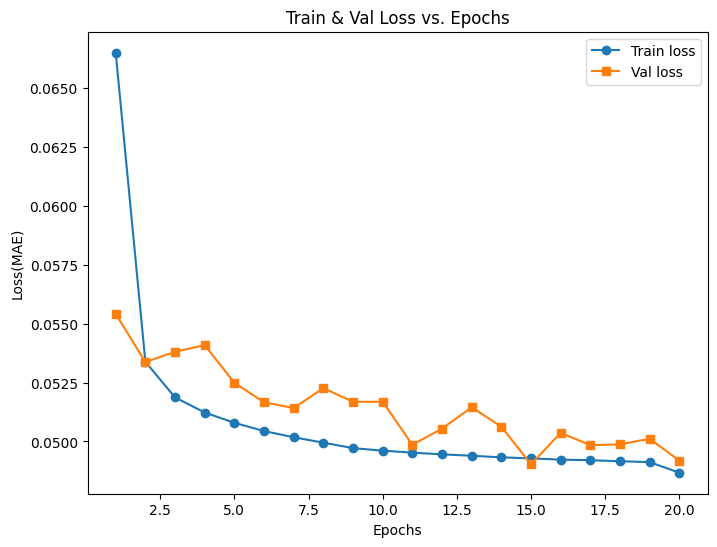

In [23]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import copy

HORIZONS = list(range(1,16))
LOOKBACK = 60
BATCH = 32
GCN_HIDDEN = 16
GCN_OUT = 8
GCN_DROPOUT = 0.2
LSTM_HIDDEN = 96
LR = 5e-4
WD = 1e-4
EPOCHS = 50
N = len(portal_ids)
A_hat = build_Ahat(portal_ids, sigma, device=device)

def make_dataset(data, lookback=60, horizons=None, stride=1):
  X, y = [], []
  max_h = max(horizons)
  for i in range(0, len(data)-lookback-max_h+1, stride):
    X.append(data[i:i+lookback,:])
    y.append(np.stack([data[i+lookback+h-1,:] for h in horizons], axis=0))
  return np.array(X, np.float32), np.array(y, np.float32)

# ======================================= Data Preparing =========================================================
train_data = train_flow_speed.values
val_data = val_flow_speed.values
test_data = test_flow_speed.values

scaler = MinMaxScaler((0,1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

X_train,y_train = make_dataset(train_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)
X_val,y_val = make_dataset(val_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)
X_test,y_test = make_dataset(test_data_scaled, lookback=LOOKBACK, horizons=HORIZONS)

# transform numpy to tensor & float32
X_train = torch.from_numpy(X_train).float()   # [N,L,2*8]
y_train = torch.from_numpy(y_train).float()   # [N,H,2*8]
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(X_train,y_train)
val_dataset = TensorDataset(X_val,y_val)
test_dataset = TensorDataset(X_test,y_test)

train_dataloader = DataLoader(train_dataset,batch_size=BATCH,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH,shuffle=False)


# ====================== Instantiate a model & Set Loss Fcunction & Optimzier ==============================

gcn_lstm = TwoLayerGCN_LSTM(A_hat=A_hat, in_feat=2, gcn_hidden=GCN_HIDDEN, gcn_out=GCN_OUT, gcn_dropout=GCN_DROPOUT,
         lstm_hidden=LSTM_HIDDEN, lstm_layers=1, out_feat=2, horizon=len(HORIZONS), N=N)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(gcn_lstm.parameters(),lr=LR,weight_decay=WD)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-6
)

# ===================== Training and test loop ==================================================================
train_losses, val_losses = [], []
best_val, best_state, wait = float("inf"), None, 0
patience_es = 5

start_time = timer()
for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n---------")
  train_loss = train_step(gcn_lstm,train_dataloader,loss_fn,optimizer,device)
  val_loss = test_step(gcn_lstm,val_dataloader,loss_fn,device)
  scheduler.step(val_loss)
  # print("current lr:", optimizer.param_groups[0]["lr"])

  train_losses.append(train_loss)
  val_losses.append(val_loss)     # for plot

  # Early Stopping
  if val_loss < best_val - 1e-6:
    best_val, best_state, wait = val_loss, copy.deepcopy(gcn_lstm.state_dict()), 0
  else:
    wait += 1
    if wait >= patience_es:
      print(f"Early stopping triggered at epoch {epoch}. Best val loss = {best_val:.5f}")
      break

if best_state is not None:
  gcn_lstm.load_state_dict(best_state)

end_time = timer()
total_time = print_train_time(start_time, end_time, device=device)

### Visualize
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, marker = "o", label="Train loss")
plt.plot(range(1, len(val_losses)+1), val_losses, marker = "s", label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss(MAE)")
plt.title("Train & Val Loss vs. Epochs")
plt.legend()
plt.show()

In [24]:
# torch.save(gcn_lstm.state_dict(), "gcn_lstm_model.pth")

In [25]:
# final test evaluation
metrics,y_true,y_pred = eval_model(model=gcn_lstm,
      data_loader=test_dataloader,
      loss_fn=loss_fn,
      device=device,
      scaler=scaler,
      horizons=HORIZONS,
      feature_names=feature_cols)
print(metrics["MAE_overall"], metrics["RMSE_overall"])
metrics["per_step_df"]

4.118696212768555 7.567783832550049


,feature,horizon,MAE,RMSE
0,FLOW,1,6.054575,8.397102
1,FLOW,2,6.561619,9.120504
2,FLOW,3,6.715544,9.428779
3,FLOW,4,6.823027,9.663248
4,FLOW,5,6.921440,9.856808
5,FLOW,6,7.056241,10.153072
6,FLOW,7,7.222599,10.420125
7,FLOW,8,7.353986,10.645302
8,FLOW,9,7.452843,10.853623
9,FLOW,10,7.557556,11.007627


In [26]:
metrics["per_step_df"].to_csv("gcn_lstm_evaluation_results.csv")